In [1]:
# import packages
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
%matplotlib notebook

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# loading MNIST
df = pd.read_csv("../../DataSet/mnist_train.csv")

In [3]:
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# input and output features
X = df.iloc[:,1:].to_numpy() / 255.0
Y = df.iloc[:,0].to_numpy()

In [5]:
# train and test split
Xtrain, Xtest, Ytrain, Ytest = X[:-1000], X[-1000:], Y[:-1000], Y[-1000:]

In [6]:
# Shuffle
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

In [7]:
# conver to float32 for Tensorflow computation
Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)

In [8]:
def showPic(x,y):
    plt.figure(figsize=(3,3))
    plt.title("Digit: " + str(y))
    plt.imshow(x.reshape(28,28))
    plt.show()

<IPython.core.display.Javascript object>


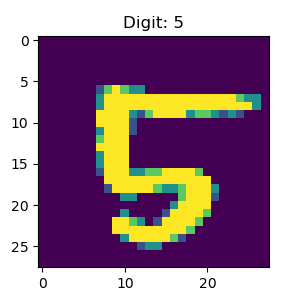

In [9]:
# test PIC
id = 1
showPic(Xtrain[id], Ytrain[id])

In [10]:
def oneHotEncode(y):
    T = np.zeros((y.shape[0], np.unique(y).shape[0]))
    
    for i,val in enumerate(y):
        T[i,val] = 1
        
    return T

In [13]:
T = oneHotEncode(Ytrain) # Apply OneHotencode to Ytrain
Tt = oneHotEncode(Ytest)
N = Xtrain.shape[0] # Num samples
D = Xtrain.shape[1] # Num input features
M = 100 # Num Hidden Nodes in 1 layer
K = T.shape[1] # Num output features
lr = 0.1 # Learning Rate
decay = 0.99
momentum = 0.99
beta1 = 0.9 # 
beta2 = 0.999 # 
iterations = 100
adam_train_loss, adam_test_loss = [], []
RMSProp_train_loss, RMSProp_test_loss = [], []
momentum_train_loss, momentum_test_loss = [], []
adagrad_train_loss, adagrad_test_loss = [], []
np.random.seed(1)

# Placeholders for Training Data
Xt = tf.placeholder(tf.float32, shape=[None, D], name="Xtrain")
Yt = tf.placeholder(tf.float32, shape=[None, K], name="Ytrain")

# Weights initialization
W1 = tf.Variable(np.random.randn(D,M).astype(np.float32), "w1")
b1 = tf.Variable(np.random.randn(M).astype(np.float32), "b1")
W2 = tf.Variable(np.random.randn(M,K).astype(np.float32), "w2")
b2 = tf.Variable(np.random.randn(K).astype(np.float32), "b2")

Z1 = tf.nn.sigmoid(tf.matmul(Xt,W1)+b1)
Z2 = tf.matmul(Z1,W2)+b2

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(Yt,Z2))

train_Adam_optimizer = tf.train.AdamOptimizer(lr,beta1,beta2,name="Adam").minimize(cost) #  Adam
train_RMSProp_optimizer = tf.train.RMSPropOptimizer(lr,decay,momentum,name="RMSProp").minimize(cost) # RMSProp
train_Adagrad_optimizer = tf.train.AdagradOptimizer(lr,1,name="Adagrad").minimize(cost) # Adadelta
train_Momentum_optimizer = tf.train.MomentumOptimizer(lr,momentum,name="Momentum").minimize(cost) # Momentum

init = tf.global_variables_initializer() # Initializing all the variables

# Train with Adam Optimizer
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(iterations):
        sess.run(train_Adam_optimizer, feed_dict={Xt:Xtrain, Yt:T})
        ctrain = sess.run(cost, feed_dict={Xt:Xtrain, Yt:T})
        ctest = sess.run(cost, feed_dict={Xt:Xtest, Yt:Tt})
        adam_train_loss.append(ctrain)
        adam_test_loss.append(ctest)
        sys.stdout.write("\nIterations: %d | Train Cost: %.3f | Test Cost: %.3f" % (i+1, ctrain, ctest))


# Train with RMSProp Optimizer
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(iterations):
        sess.run(train_RMSProp_optimizer, feed_dict={Xt:Xtrain, Yt:T})
        ctrain = sess.run(cost, feed_dict={Xt:Xtrain, Yt:T})
        ctest = sess.run(cost, feed_dict={Xt:Xtest, Yt:Tt})
        RMSProp_train_loss.append(ctrain)
        RMSProp_test_loss.append(ctest)
        sys.stdout.write("\nIterations: %d | Train Cost: %.3f | Test Cost: %.3f" % (i+1, ctrain, ctest))
        
# Train with Adadelta Optimizer
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(iterations):
        sess.run(train_Adagrad_optimizer, feed_dict={Xt:Xtrain, Yt:T})
        ctrain = sess.run(cost, feed_dict={Xt:Xtrain, Yt:T})
        ctest = sess.run(cost, feed_dict={Xt:Xtest, Yt:Tt})
        adagrad_train_loss.append(ctrain)
        adagrad_test_loss.append(ctest)
        sys.stdout.write("\nIterations: %d | Train Cost: %.3f | Test Cost: %.3f" % (i+1, ctrain, ctest))

# Train with Momentum Optimizer
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(iterations):
        sess.run(train_Momentum_optimizer, feed_dict={Xt:Xtrain, Yt:T})
        ctrain = sess.run(cost, feed_dict={Xt:Xtrain, Yt:T})
        ctest = sess.run(cost, feed_dict={Xt:Xtest, Yt:Tt})
        momentum_train_loss.append(ctrain)
        momentum_test_loss.append(ctest)
        sys.stdout.write("\nIterations: %d | Train Cost: %.3f | Test Cost: %.3f" % (i+1, ctrain, ctest))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Iterations: 1 | Train Cost: 9.120 | Test Cost: 8.495
Iterations: 2 | Train Cost: 6.661 | Test Cost: 6.263
Iterations: 3 | Train Cost: 5.454 | Test Cost: 5.242
Iterations: 4 | Train Cost: 4.619 | Test Cost: 4.300
Iterations: 5 | Train Cost: 4.329 | Test Cost: 4.064
Iterations: 6 | Train Cost: 3.203 | Test Cost: 2.971
Iterations: 7 | Train Cost: 2.084 | Test Cost: 1.823
Iterations: 8 | Train Cost: 1.406 | Test Cost: 1.106
Iterations: 9 | Train Cost: 1.099 | Test Cost: 0.824
Iterations: 10 | Train Cost: 1.280 | Test Cost: 0.981
Iterations: 11 | Train Cost: 1.471 | Test Cost: 1.170
Iterations: 12 | Train Cost: 1.283 | Test Cost: 1.037
Iterations: 13 | Train Cost: 1.048 | Test Cost: 0.869
Iterations: 14 | Train Cost: 0.940 | Test Cost: 0.788
Iterations: 15 | Train Cost: 0.901 | Test Cost: 0.764
Iterations: 16 | Train Cost: 0.867 | Test Cost: 0.725
Iterations: 17 | Train Cos

Iterations: 47 | Train Cost: 0.948 | Test Cost: 0.743
Iterations: 48 | Train Cost: 0.910 | Test Cost: 0.737
Iterations: 49 | Train Cost: 0.903 | Test Cost: 0.753
Iterations: 50 | Train Cost: 0.919 | Test Cost: 0.787
Iterations: 51 | Train Cost: 0.948 | Test Cost: 0.828
Iterations: 52 | Train Cost: 0.980 | Test Cost: 0.866
Iterations: 53 | Train Cost: 1.005 | Test Cost: 0.895
Iterations: 54 | Train Cost: 1.017 | Test Cost: 0.907
Iterations: 55 | Train Cost: 1.010 | Test Cost: 0.897
Iterations: 56 | Train Cost: 0.982 | Test Cost: 0.861
Iterations: 57 | Train Cost: 0.935 | Test Cost: 0.805
Iterations: 58 | Train Cost: 0.880 | Test Cost: 0.738
Iterations: 59 | Train Cost: 0.835 | Test Cost: 0.677
Iterations: 60 | Train Cost: 0.814 | Test Cost: 0.643
Iterations: 61 | Train Cost: 0.824 | Test Cost: 0.639
Iterations: 62 | Train Cost: 0.859 | Test Cost: 0.658
Iterations: 63 | Train Cost: 0.902 | Test Cost: 0.686
Iterations: 64 | Train Cost: 0.931 | Test Cost: 0.707
Iterations: 65 | Train Cost:

Iterations: 99 | Train Cost: 2.619 | Test Cost: 2.451
Iterations: 100 | Train Cost: 2.605 | Test Cost: 2.436
Iterations: 1 | Train Cost: 6.667 | Test Cost: 6.833
Iterations: 2 | Train Cost: 6.161 | Test Cost: 6.285
Iterations: 3 | Train Cost: 5.672 | Test Cost: 5.735
Iterations: 4 | Train Cost: 5.312 | Test Cost: 5.303
Iterations: 5 | Train Cost: 5.145 | Test Cost: 5.082
Iterations: 6 | Train Cost: 5.172 | Test Cost: 5.068
Iterations: 7 | Train Cost: 5.249 | Test Cost: 5.114
Iterations: 8 | Train Cost: 5.147 | Test Cost: 4.985
Iterations: 9 | Train Cost: 4.727 | Test Cost: 4.545
Iterations: 10 | Train Cost: 4.058 | Test Cost: 3.873
Iterations: 11 | Train Cost: 3.385 | Test Cost: 3.207
Iterations: 12 | Train Cost: 2.934 | Test Cost: 2.758
Iterations: 13 | Train Cost: 2.722 | Test Cost: 2.545
Iterations: 14 | Train Cost: 2.650 | Test Cost: 2.463
Iterations: 15 | Train Cost: 2.645 | Test Cost: 2.438
Iterations: 16 | Train Cost: 2.664 | Test Cost: 2.436
Iterations: 17 | Train Cost: 2.627 |

<IPython.core.display.Javascript object>


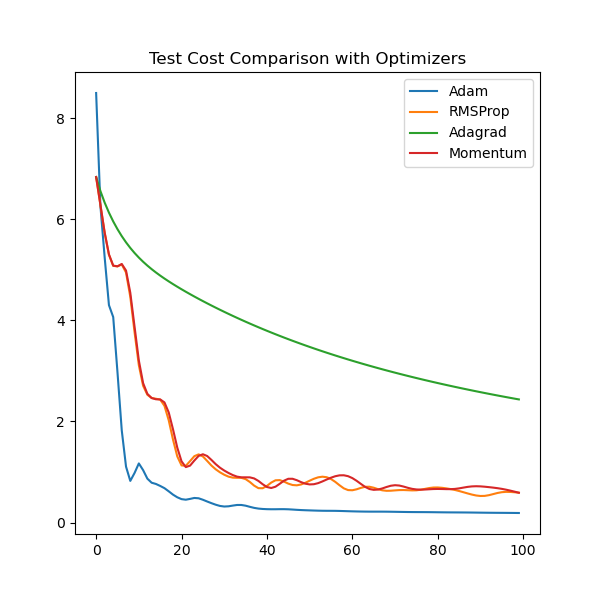

In [14]:
plt.figure(figsize=(6,6))
plt.title("Test Cost Comparison with Optimizers")
plt.plot(adam_test_loss, label="Adam")
plt.plot(RMSProp_test_loss, label="RMSProp")
plt.plot(adagrad_test_loss, label="Adagrad")
plt.plot(momentum_test_loss, label="Momentum")
plt.legend()
plt.show()